<a href="https://colab.research.google.com/github/S1R3S1D/PINNxMICROFLUIDICS/blob/main/Couette_Flow_NSFnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from mpl_toolkits import mplot3d

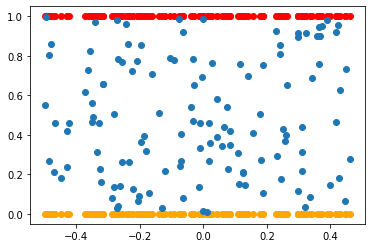

In [3]:
#Cloud Generator

domain_X = [-.5, .5]
domain_Y = [0, 1]

rng = np.random.default_rng(123)

def cloud(size=128):
  
  #interior
  X = rng.uniform(domain_X[0], domain_X[1], size)
  Y = rng.uniform(domain_Y[0], domain_Y[1], size)

  return (X, Y)

#Random Plotting in Domain
x, y = cloud(128)
plt.scatter(x, np.zeros_like(x), color='orange')
plt.scatter(x, np.ones_like(x), color='red')
plt.scatter(x, y)
plt.show()

In [16]:
class NSFnet_VP(nn.Module):
  def __init__(self):
    super().__init__()

    self.FC1 = nn.Linear(2, 64)
    self.AC1 = nn.Tanh()

    self.FC2 = nn.Linear(64, 128)
    self.AC2 = nn.Tanh()

    self.FC3 = nn.Linear(128, 2)

  def forward(self, x):
    out = self.AC1(self.FC1(x))
    out = self.AC2(self.FC2(out))
    out = self.FC3(out)
    return out

In [17]:
model = NSFnet_VP()
lr=0.01
optimizer = torch.optim.Adam(model.parameters(), lr)
epochs = 10000

In [18]:
for epoch in tqdm(range(epochs)):

  #Data
  size = 128
  x_sample, y_sample = cloud(size)
  x_t = torch.tensor(x_sample, dtype=torch.float, requires_grad=True)
  y_t = torch.tensor(y_sample, dtype=torch.float, requires_grad=True)
  data = torch.stack([torch.cat([x_t, x_t, x_t], dim=0), torch.cat([y_t, torch.ones_like(y_t), torch.zeros_like(y_t)])], dim=1)

  #PDE Predictions
  preds = model(data)
  u_preds = preds[:size, 0]#Velocity
  p_preds = preds[:size, 1]#Pressure

  #Differentials
  du_dx = torch.autograd.grad(u_preds, x_t, torch.ones_like(u_preds), create_graph=True, retain_graph=True)[0]
  du_dy = torch.autograd.grad(u_preds, y_t, torch.ones_like(u_preds), create_graph=True, retain_graph=True)[0]
  d2u_dy2 = torch.autograd.grad(du_dy, y_t, torch.ones_like(u_preds), create_graph=True, retain_graph=True)[0]

  dp_dx = torch.autograd.grad(p_preds, x_t, torch.ones_like(p_preds), create_graph=True, retain_graph=True)[0]
  dp_dy = torch.autograd.grad(p_preds, y_t, torch.ones_like(p_preds), create_graph=True, retain_graph=True)[0]

  #Losses
  mu = 1

  #PDE_Loss
  loss = torch.sum(du_dx**2)
  loss = loss + torch.sum(dp_dy**2)
  loss = loss + torch.sum((dp_dx-100)**2)
  loss = loss + torch.sum((dp_dx-mu*(d2u_dy2))**2)
  loss_p = loss

  #Boundary Loss
  v = -5
  loss = torch.sum((preds[size:size*2,0]-v)**2)
  loss = loss+torch.sum((preds[size*2:size*3,0])**2)
  loss_b = loss

  alpha_b = 0.01

  #Total loss
  loss = loss_p + alpha_b*loss_b 

  if(epoch%1000==0 or epoch==9999):
    print("PDE Loss:", loss_p.item(), ", Boundary Loss:", loss_b.item())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  0%|          | 20/10000 [00:00<01:43, 96.43it/s]

PDE Loss: 1279680.875 , Boundary Loss: 2852.49755859375


 10%|█         | 1020/10000 [00:10<01:30, 99.02it/s]

PDE Loss: 260.9871826171875 , Boundary Loss: 55.47825241088867


 20%|██        | 2016/10000 [00:20<01:19, 100.39it/s]

PDE Loss: 93.82308959960938 , Boundary Loss: 15.467154502868652


 30%|███       | 3017/10000 [00:30<01:12, 96.64it/s]

PDE Loss: 77.89093780517578 , Boundary Loss: 8.485267639160156


 40%|████      | 4017/10000 [00:43<01:02, 95.89it/s]

PDE Loss: 7.731398582458496 , Boundary Loss: 0.3911493122577667


 50%|█████     | 5012/10000 [00:53<00:51, 96.23it/s]

PDE Loss: 15.618690490722656 , Boundary Loss: 4.684292316436768


 60%|██████    | 6019/10000 [01:04<00:40, 98.89it/s]

PDE Loss: 50.50252151489258 , Boundary Loss: 9.400203704833984


 70%|███████   | 7016/10000 [01:14<00:29, 99.92it/s]

PDE Loss: 60.94876480102539 , Boundary Loss: 2.177893877029419


 80%|████████  | 8013/10000 [01:24<00:20, 94.64it/s]

PDE Loss: 7.383665561676025 , Boundary Loss: 0.41527336835861206


 90%|█████████ | 9016/10000 [01:34<00:10, 95.02it/s]

PDE Loss: 107.6478271484375 , Boundary Loss: 12.527738571166992


100%|██████████| 10000/10000 [01:45<00:00, 94.47it/s]

PDE Loss: 2.998605251312256 , Boundary Loss: 0.33087170124053955


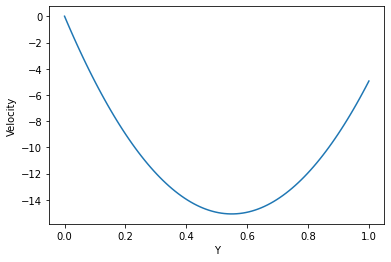

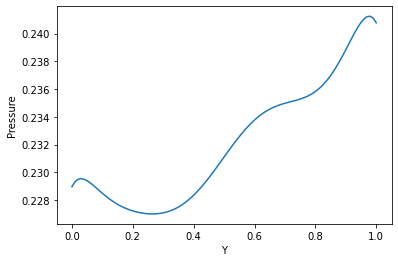

In [19]:
#Plotting Results

y = np.linspace(domain_Y[0], domain_Y[1], 100)
x = np.zeros_like(y)

x_t = torch.tensor(x, dtype=torch.float)
y_t = torch.tensor(y, dtype=torch.float)

with torch.no_grad():
  preds = model(torch.stack([x_t, y_t], dim=1))

u_preds = preds[:, 0].numpy()
p_preds = preds[:, 1].numpy()

plt.plot(y, u_preds,)
plt.xlabel('Y')
plt.ylabel('Velocity')
plt.show()

plt.plot(y, p_preds)
plt.xlabel('Y')
plt.ylabel('Pressure')
plt.show()